In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import hvplot.pandas
from MCForecastTools import MCSimulation

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create empty disctionary of user's portfolio for analisys 
portfolio = {}

# Get portfolio tickers and shares from a user, defined period user analysis and fetch closing prices for a portfolio.
# Run Infinite loop "while True" to get as much stock tickers as user wishes to analysis and break when finished "Done". 
# Use input function for user interactions 
while True:
    
#The use of upper() in the provided code is to convert the user-inputted stock symbol to uppercase letters.
    stock = input("Enter a stock symbol (or 'done' to finish): ").upper() 
    if stock == 'DONE':
        break
    quantity = float(input(f"Enter the quantity of {stock}: "))
    portfolio[stock] = quantity

# Locate and convert the ".keys()" and ".values()" in dictionary to the list.
portfolio_tickers = list(portfolio.keys())
stock_shares = list(portfolio.values())

# Create empty disctionaty for historical_data to save all downloaded data.
# Run "for" loop to iterate through each stock ticker in the list and download closing data in defined period of time.
historical_data = {}
for stock_symbol in portfolio.keys():
    stock_data = yf.download(stock_symbol, period="5y")
    historical_data[stock_symbol] = stock_data['Close']


Enter a stock symbol (or 'done' to finish):  btc-usd
Enter the quantity of BTC-USD:  .1
Enter a stock symbol (or 'done' to finish):  eth-usd
Enter the quantity of ETH-USD:  2
Enter a stock symbol (or 'done' to finish):  done


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def portfolio_value(portfolio_tickers, stock_shares):
    try:
        # Download historical stock prices
        data = yf.download(portfolio_tickers, period="1d")['Close']
        
        # Get the latest prices
        current_prices = data.iloc[-1]
        
        # Calculate the value of each stock
        stock_values = current_prices * pd.Series(portfolio)
        
        # Calculate the total portfolio value
        portfolio_value = stock_values.sum()
        
        return portfolio_value
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Calculate portfolio value
current_portfolio_value = portfolio_value(portfolio_tickers, stock_shares)

# Display the current portfolio value
print(f"\nCurrent Portfolio Value: ${current_portfolio_value:.2f}")

[*********************100%%**********************]  2 of 2 completed

Current Portfolio Value: $8952.34


[*********************100%%**********************]  2 of 2 completed


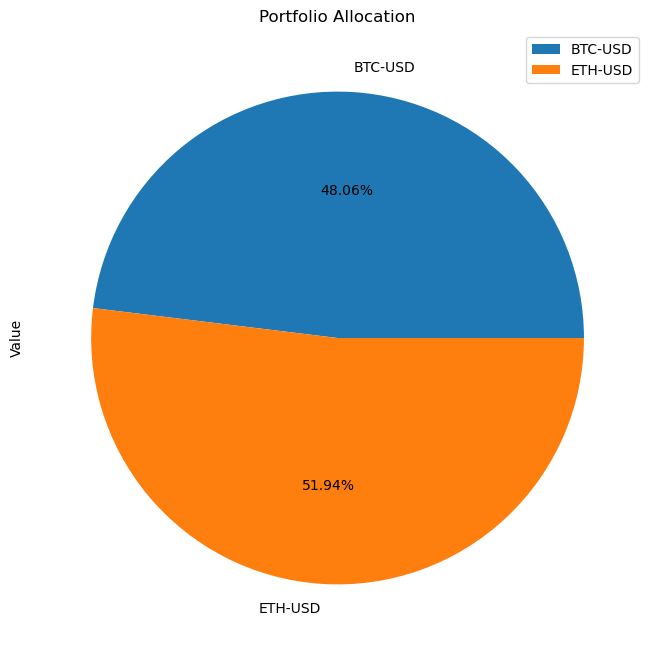

In [4]:
# Fetch stocks closing prices in the portfolio for period of one day .
data = yf.download(portfolio_tickers, period="1d")['Close'] 
current_prices = data.iloc[-1]

# Locate shares owned and calculate current values of each stock in the portfolio.
stock_shares = pd.Series(stock_shares, index=portfolio_tickers)
each_stock_value = pd.DataFrame((current_prices * stock_shares).round(2))

# Calculate percentage of each stock in the portfolio.
percentage_of_portfolio = ((each_stock_value / current_portfolio_value) * 100).round(2)

# Combine stocks values and percetage allocation in to one dataframe, define columns name and plot pie chart.
portfolio_summary = pd.concat([each_stock_value, percentage_of_portfolio], axis=1)
portfolio_summary.columns = ['Value', 'Percentage']
portfolio_summary.plot.pie(y='Value', 
                           autopct='%1.2f%%', 
                           title="Portfolio Allocation", 
                           figsize=(8, 8))
plt.legend(loc='upper right')

# Save plot in the images folder.
plt.savefig('images/portfolio_allocation.png')

In [5]:
# Fetch the closing data for Sp 500, Define period you wish to work with.
sp500_data = yf.download('^GSPC',  period="5y") 
sp500_closing_prices = sp500_data['Close']

# Convert to pandas DataFrame, Rename cloumn name to SP500.
sp500_closing_prices = pd.DataFrame(sp500_closing_prices)
sp500_closing_prices.columns = ['SP500']

#  Calculate daily retuns of the Market and drop na.
sp500_returns = sp500_closing_prices.pct_change().dropna()

# Convert historical data of portfolio to pandas DataFrame and Calculate daily retuns of portfolio and drop na. 
historical_data = pd.DataFrame(historical_data)

portfolio_returns = historical_data.pct_change().dropna()

# Combine market and portfolio returns to one DataFrame.
combined_returns = pd.merge(sp500_returns, portfolio_returns, on='Date')
combined_returns

[*********************100%%**********************]  1 of 1 completed


,SP500,BTC-USD,ETH-USD
Date,,,
2019-01-02,0.001268,0.025989,0.101039
2019-01-03,-0.024757,-0.027050,-0.038135
2019-01-04,0.034336,0.005467,0.036523
2019-01-07,0.007010,-0.012605,-0.038334
2019-01-08,0.009695,0.001391,-0.008831
...,...,...,...
2023-12-22,0.001660,0.002935,0.038839
2023-12-26,0.004232,-0.025055,-0.018084
2023-12-27,0.001430,0.021694,0.065999


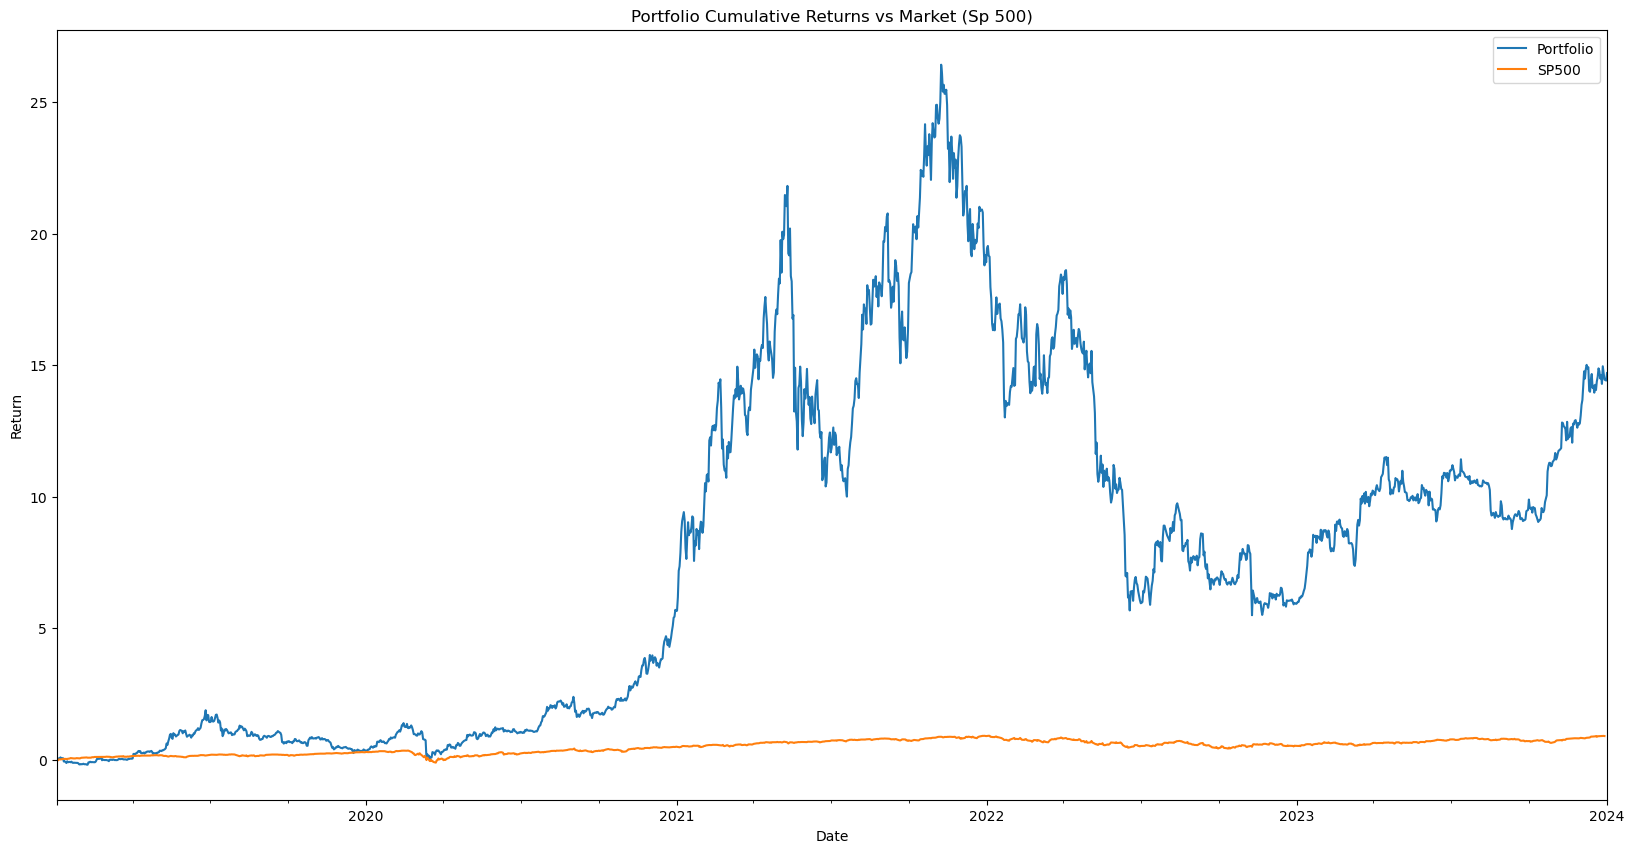

In [6]:
# Sum the average returns of the portfolio and calculate cumulative returns of the portfolio and then plot it.
portfolio_average_returns = portfolio_returns.mean(axis=1)
portfolio_cumulative_returns = (1 + portfolio_average_returns).cumprod() - 1
ax = portfolio_cumulative_returns.plot(figsize=(20,10), 
                        ylabel='Return',
                        title='Portfolio Cumulative Returns vs Market (Sp 500)',
                        label='Portfolio',
                        legend=True)
# Calculate cumulative returns of th market and plot it against our portfolio.
spy500_cumulative_returns = (1 + sp500_returns).cumprod() - 1
spy500_cumulative_returns.plot(ax=ax, label='SP500', legend=True)

# Save plot in the images folder.
plt.savefig('images/cumulative_returns.png')

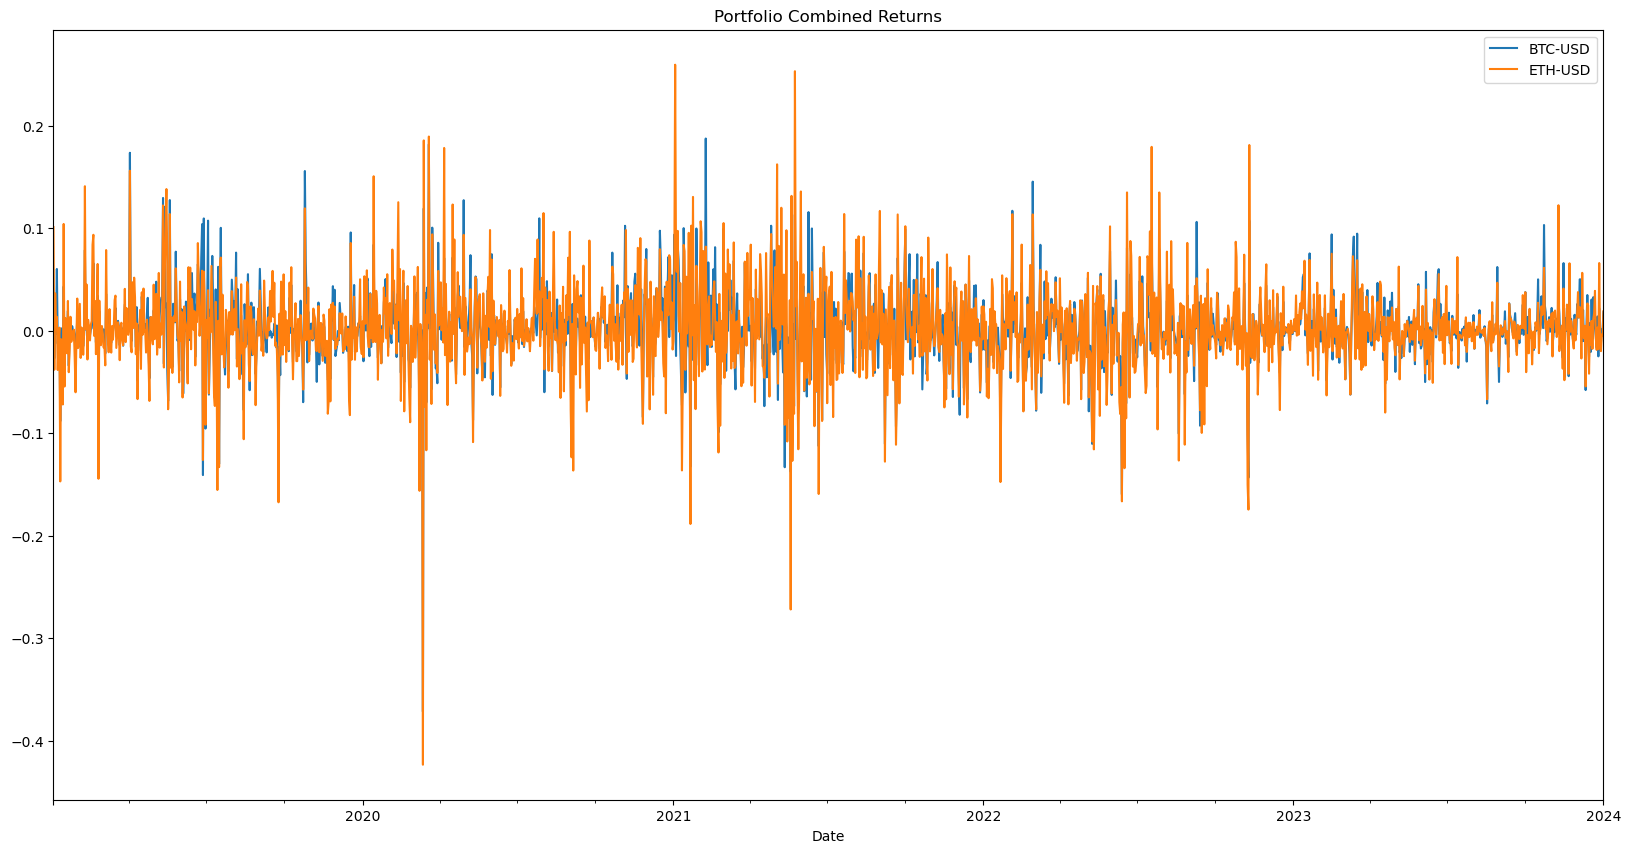

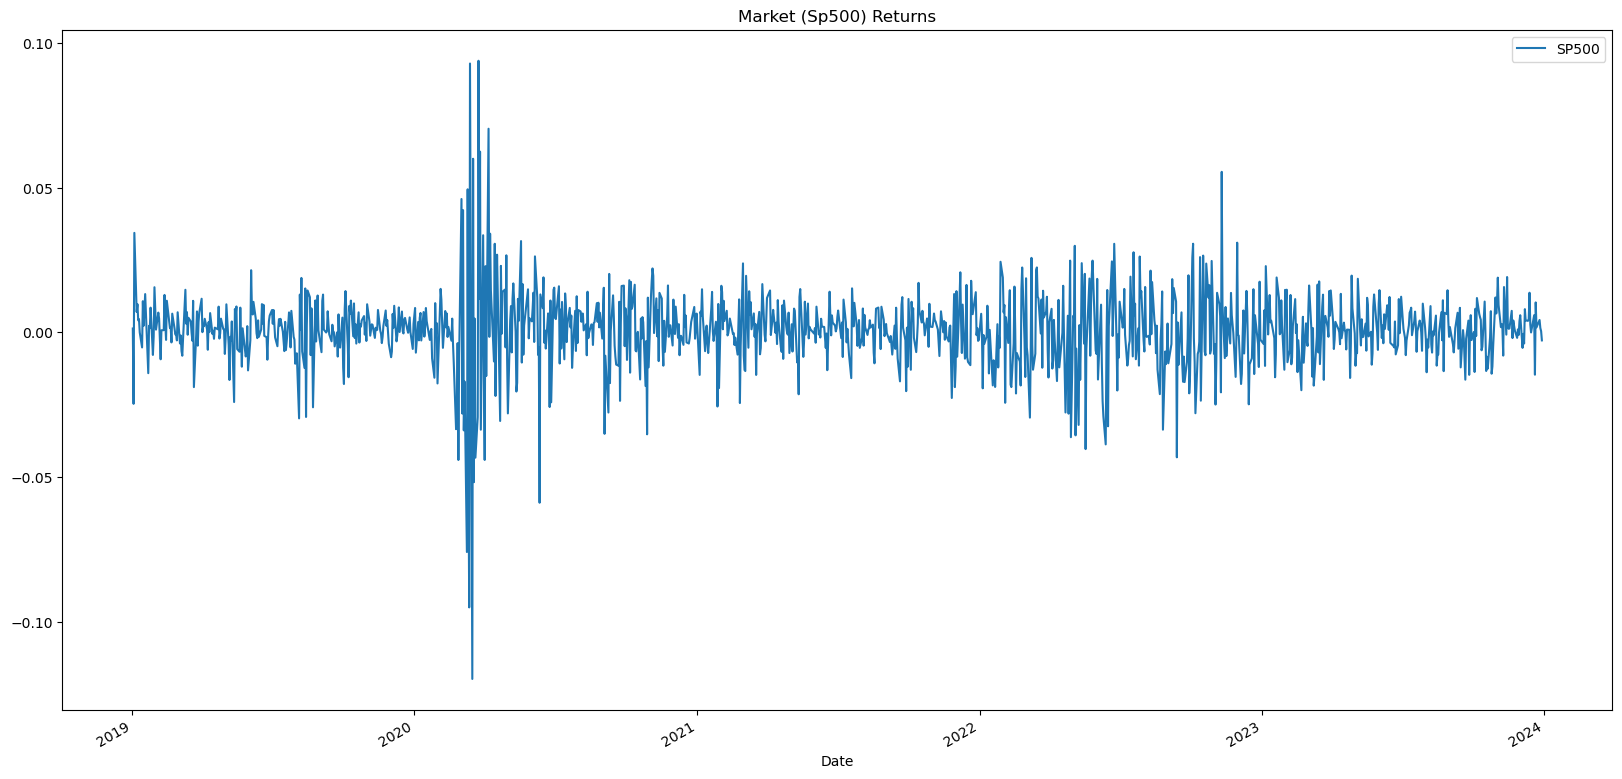

In [7]:
portfolio_returns.plot(figsize=(20,10),title='Portfolio Combined Returns', legend=True)
sp500_returns.plot(figsize=(20,10),title='Market (Sp500) Returns', legend=True)
plt.savefig('images/portfolio_returns.png')
plt.savefig('images/sp500_returns.png')

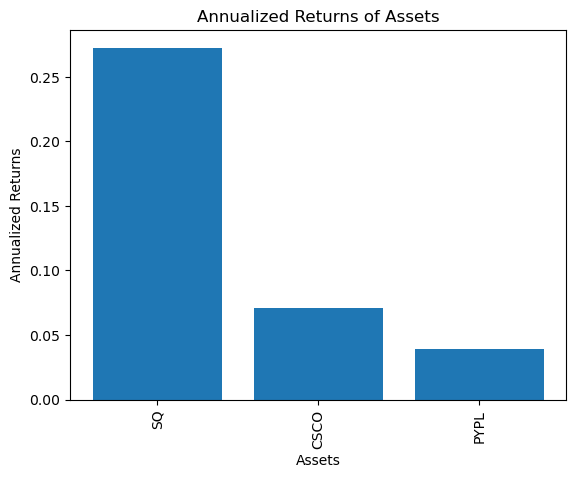

In [13]:
# define the risk free rate
risk_free_rate = 0.04/252 # annualized yield of 3-month Treasury bill divided by 252 trading days

# calculate the excess returns of each stock in the portfolio
excess_returns = portfolio_returns * stock_shares - risk_free_rate


# Calculate the annual returns
annual_daily_returns = portfolio_returns.mean() * 252
annual_excess_returns = excess_returns.mean() * 252

# Calculate the daily standard deviations
portfolio_returns_std = portfolio_returns.std()

# CAluculating the excess returns
excess_returns_std = excess_returns.std()


######### annual STD

# Calculate the annualized standard deviation (252 trading days)
stock_annualized_std = portfolio_returns_std * np.sqrt(252)
portfolio_annualized_std = excess_returns_std * np.sqrt(252)

# Calculate the stock risk
annual_stock_risk = portfolio_returns_std * math.sqrt(252)
annual_excess_risk = excess_returns_std * math.sqrt(252)

# Sorted the data in decending order
sorted_annual_returns = annual_daily_returns.sort_values(ascending=False)
sorted_annual_excess_returns = annual_excess_returns.sort_values(ascending=False)


# plot the sorted annualized returns of stock
plt.bar(sorted_annual_returns.index, sorted_annual_returns)
plt.ylabel("Annualized Returns")
plt.xlabel('Assets')

plt.xticks(rotation=90)
plt.title('Annualized Returns of Assets')
plt.savefig('images/annualized_returns.png')

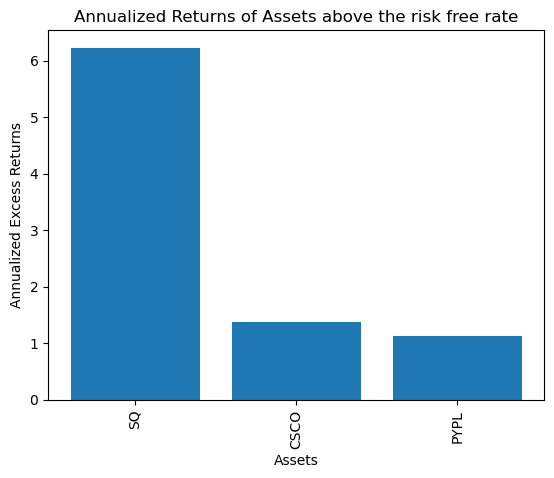

In [14]:
# Plot of the excess annual returns
# plot the sorted annualized returns of stock
plt.bar(sorted_annual_excess_returns.index, sorted_annual_excess_returns)
plt.ylabel("Annualized Excess Returns")
plt.xlabel('Assets')
plt.xticks(rotation=90)
plt.title('Annualized Returns of Assets above the risk free rate')
plt.show()

In [15]:
# creat a dataframe to store the annual returns, annual risks, annual excess returns and company ticker and new column for the ratio

risk_df = pd.DataFrame()
risk_df['Expected Annual Returns'] = annual_daily_returns
risk_df['Expected Annual Risk'] = annual_stock_risk
risk_df['Expected Annual Excess Returns'] = annual_excess_returns
risk_df['Stock'] = portfolio_tickers
risk_df['Ratio'] = risk_df['Expected Annual Returns'] / risk_df['Expected Annual Risk']

# show in decending order for the expected annual returns
risk_df.sort_values(by="Ratio", axis = 0, ascending=False, inplace=False)

,Expected Annual Returns,Expected Annual Risk,Expected Annual Excess Returns,Stock,Ratio
SQ,0.272612,0.635498,6.230080,SQ,0.428974
CSCO,0.070938,0.282840,1.378769,CSCO,0.250808
PYPL,0.038855,0.436828,1.125654,PYPL,0.088948


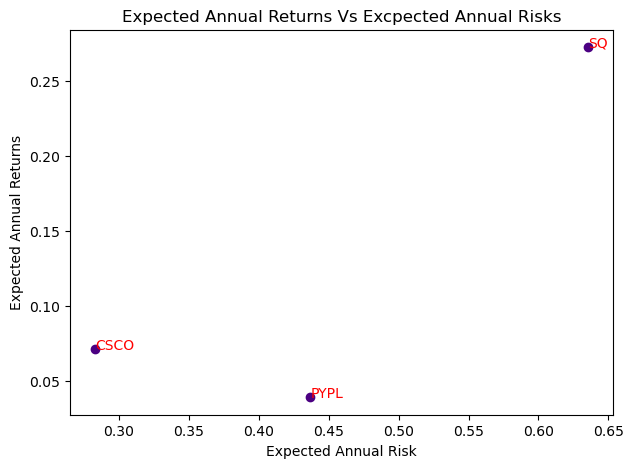

In [16]:
# visually show the ecpected annual returns vs the expected annual risk
risk_df.hvplot.bar()

fig, ax = plt.subplots(figsize=(7,5))
plt.title('Expected Annual Returns Vs Excpected Annual Risks')
ax.scatter(risk_df['Expected Annual Risk'], risk_df['Expected Annual Returns'], c = "indigo")
ax.set_xlabel('Expected Annual Risk')
ax.set_ylabel('Expected Annual Returns')
          
# note the points on plot
for idx, row in risk_df.iterrows():
    ax.annotate(row["Stock"], (row['Expected Annual Risk'], row['Expected Annual Returns']), c = 'red')
plt.savefig('images/portfolio_risk_return.png')

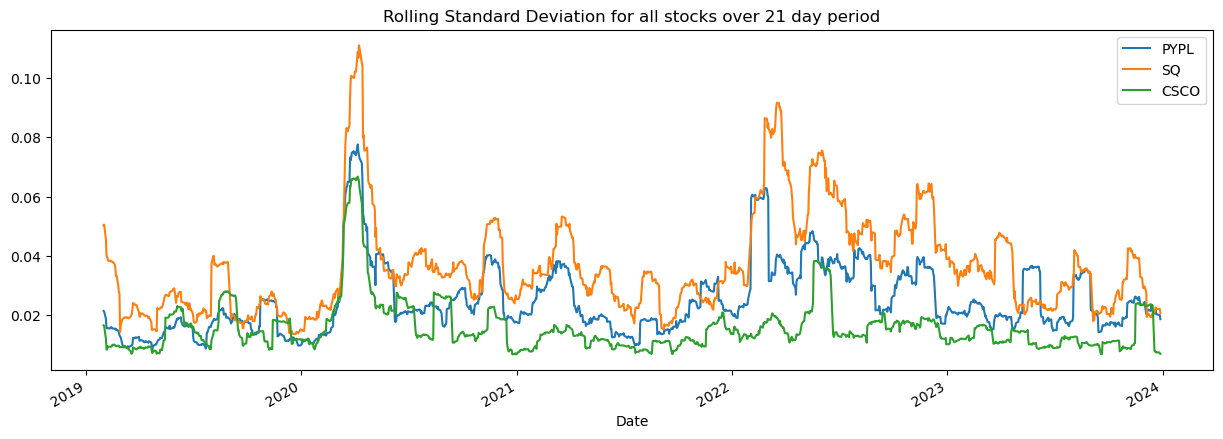

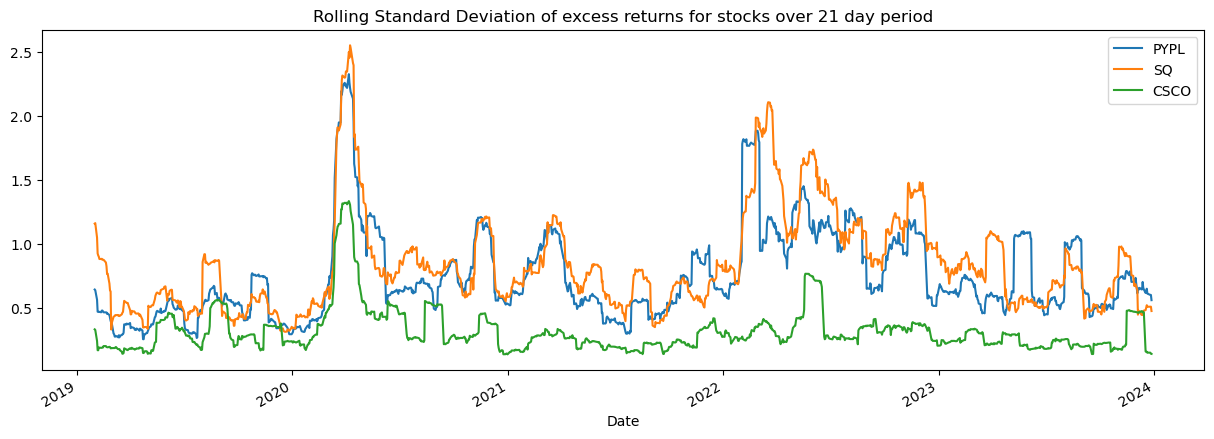

In [17]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
rolling_std = portfolio_returns.rolling(window=21).std()
excess_rolling_std = excess_returns.rolling(window=21).std()

# Plot the rolling standard deviation
rolling_std.plot(figsize=(15,5), title= 'Rolling Standard Deviation for all stocks over 21 day period')
# Plotting excess
excess_rolling_std.plot(figsize=(15,5), title= 'Rolling Standard Deviation of excess returns for stocks over 21 day period')
plt.savefig('images/standard_deviation.png')
plt.savefig('images/excess_return.png')

In [18]:
# calculte the sharpe ratio -- sharpe ratio lower than 1 is bad, 1 is ok, 3 is the best
sharpe_ratio = np.sqrt(252) * portfolio_returns / portfolio_returns_std

# calculating the sharpe ratio of our excess returns
sharpe_ratio_portfolio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# plot the stocks sharpe ratio
sharpe_ratio.hvplot.bar().opts(yformatter='%.0f',
                                      active_tools=[])

:Bars   [Date,Variable]   (value)

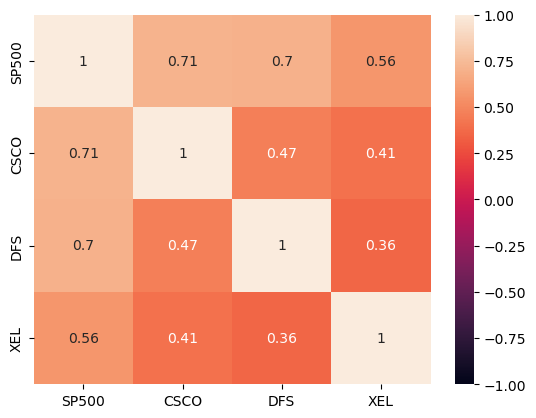

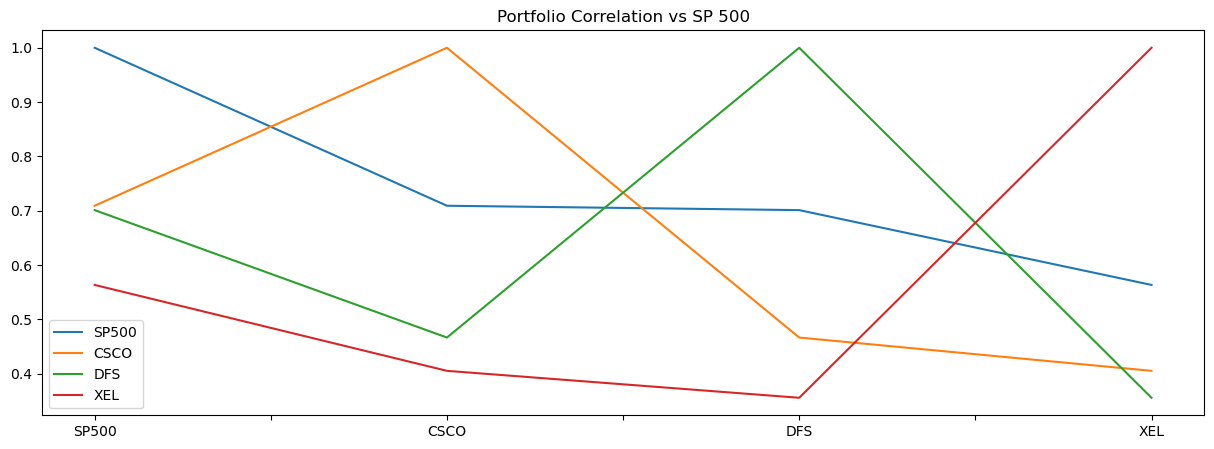

In [57]:
# Calculate the correlation
correlation_matrix = combined_returns.corr()
# Display de correlation matrix
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
plt.savefig('images/correlation_heatmap.png')

correlation_matrix.plot(figsize=(15,5), title='Portfolio Correlation vs SP 500')
plt.savefig('images/correlation_matrix.png')

In [58]:
# Calculate portflio weight
portfolio_weights = [(percentage / 100) for percentage in portfolio_summary['Percentage'].tolist()]

portfolio_tickers = list(portfolio.keys())
stock_shares = list(portfolio.values())

# Create empty disctionaty for portfolio data to save all downloaded data.
# Run "for" loop to iterate through each stock ticker in the list and 
# download all data in defined period of time.

portfolio_data = {}
for stock_symbol in portfolio.keys():
    stock_data = yf.download(stock_symbol, period="5y")
    portfolio_data[stock_symbol] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [50]:
portfolio

{'CSCO': 43.0, 'DFS': 15.0}

In [59]:
# Concatenate portfolio data, concatenate along the columns and asign keys for each stock
portfolio_data_df = pd.concat(portfolio_data.values(),  axis=1, keys=portfolio_data.keys())

# Change column names to upper case for tickers and lower case for definition
portfolio_data_df.columns = portfolio_data_df.columns.map(lambda x: (x[0].upper(), x[1].lower()))


# Difine number of simulation
num_sims = 500

# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10years = MCSimulation(
    portfolio_data = portfolio_data_df,
    weights = portfolio_weights,
    num_simulation = num_sims,
    num_trading_days = 252*10
)
MC_10years.portfolio_data.dropna()

CSCO                                                        \
                 open       high        low      close  adj close    volume   
Date                                                                          
2019-01-02  42.279999  43.200001  42.209999  42.950001  36.906460  23833500   
2019-01-03  42.299999  42.410000  40.959999  41.070000  35.564251  29606700   
2019-01-04  41.849998  43.000000  41.529999  42.919998  37.166245  27515000   
2019-01-07  42.860001  43.650002  42.759998  43.209999  37.417374  19488100   
2019-01-08  43.570000  43.939999  43.099998  43.560001  37.720459  22071400   
...               ...        ...        ...        ...        ...       ...   
2023-12-21  49.930000  49.980000  49.380001  49.700001  49.700001  18772300   
2023-12-22  49.840000  50.389999  49.840000  50.090000  50.090000  12900700   
2023-12-26  50.110001  50.400002  50.049999  50.279999  50.279999   9721200   
2023-12-27  50.299999  50.560001  50.279999  50.439999  50.439999  10414300   
2023-12-28  50.580002  50.630001  50.419998  50.480000  50.480000   8549600   

                                DFS                          ...              \
           daily_return        open        high         low  ...   adj close   
Date                                                         ...               
2019-01-02    -0.008770   57.919998   59.889999   57.790001  ...   52.753483   
2019-01-03    -0.043772   59.040001   59.410000   58.160000  ...   51.865517   
2019-01-04     0.045045   59.630001   61.480000   59.439999  ...   54.422832   
2019-01-07     0.006757   61.080002   62.110001   60.810001  ...   54.511631   
2019-01-08     0.008100   62.139999   62.669998   61.270000  ...   54.609314   
...                 ...         ...         ...         ...  ...         ...   
2023-12-21    -0.002008  109.070000  111.430000  108.930000  ...  111.160004   
2023-12-22     0.007847  111.599998  111.910004  110.529999  ...  110.989998   
2023-12-26     0.003793  110.839996  111.680000  110.779999  ...  111.650002   
2023-12-27     0.003182  111.500000  112.300003  111.250000  ...  112.239998   
2023-12-28     0.000793  112.239998  112.669998  111.910004  ...  112.570000   

                                        XEL                                   \
             volume daily_return       open       high        low      close   
Date                                                                           
2019-01-02  2096700     0.007291  49.160000  49.240002  47.950001  48.220001   
2019-01-03  2363400    -0.016832  48.270000  48.680000  47.869999  48.029999   
2019-01-04  2093000     0.049307  47.700001  48.570000  47.700001  48.500000   
2019-01-07  2460900     0.001632  48.259998  48.580002  47.950001  48.290001   
2019-01-08  2688900     0.001792  48.259998  48.889999  48.090000  48.849998   
...             ...          ...        ...        ...        ...        ...   
2023-12-21  1351300     0.032894  61.310001  61.880001  61.000000  61.529999   
2023-12-22   825400    -0.001529  61.980000  62.430000  61.810001  62.060001   
2023-12-26   644900     0.005947  61.980000  62.509998  61.970001  62.250000   
2023-12-27   743000     0.005284  61.730000  61.799999  61.369999  61.540001   
2023-12-28   728400     0.002940  61.520000  62.020000  61.410000  61.889999   

                                             
            adj close   volume daily_return  
Date                                         
2019-01-02  41.850048  4476100    -0.021311  
2019-01-03  41.685146  5287600    -0.003940  
2019-01-04  42.093056  5535600     0.009786  
2019-01-07  41.910793  4208100    -0.004330  
2019-01-08  42.396820  3128300     0.011597  
...               ...      ...          ...  
2023-12-21  61.016014  2807700     0.003588  
2023-12-22  61.541588  2429300     0.008614  
2023-12-26  61.730000  2147500     0.003062  
2023-12-27  61.540001  2865900    -0.011406  
2023-12-28  61.889999  2421900     0.005687  

[1257 rows x 21 columns

In [60]:
# Run monte carlo simulation
MC_10years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.011855,1.026364,0.992589,0.963360,0.990838,0.978767,0.986350,1.005516,1.006140,1.004584,...,1.008916,1.010136,1.011092,0.993460,0.979886,0.993601,0.979357,0.990318,1.003492,1.001425
2,0.999247,1.041374,0.985823,0.965212,1.004492,0.970863,0.982715,0.985024,1.027734,1.021665,...,1.011699,1.004493,0.989044,0.992096,0.955798,1.005520,0.971035,1.001973,0.996051,0.994986
3,0.997432,1.032844,0.973224,0.955710,1.007223,0.981229,0.980630,0.985701,1.039527,1.026105,...,1.009652,1.030414,1.003900,0.985672,0.956669,1.013108,0.981643,1.008942,1.000063,0.998238
4,1.000951,1.046335,0.954496,0.965480,0.998943,0.990439,0.986110,0.974144,1.019689,1.025738,...,1.007021,1.035181,0.988797,0.987437,0.972485,1.009502,0.971558,1.017985,0.974121,1.002656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,4.402641,5.838841,3.996268,3.796589,8.618660,1.943477,3.809747,3.479944,7.174828,2.488143,...,4.006624,11.931636,8.033780,5.653239,5.591628,3.103408,1.255135,2.900606,7.623491,3.163780
2517,4.358308,5.811715,4.126456,3.737639,8.681322,1.927328,3.870100,3.443101,7.189309,2.486859,...,4.034199,11.940434,8.131281,5.660438,5.643185,3.097664,1.246985,2.953594,7.428118,3.133020
2518,4.384753,5.699067,4.090679,3.755684,8.787997,1.983209,3.920307,3.436354,7.175936,2.425317,...,4.000999,11.862965,8.352782,5.730665,5.770360,3.099370,1.258239,2.991239,7.424663,3.169482
2519,4.373702,5.655193,4.124626,3.745676,8.747021,1.964270,4.053257,3.374808,7.144306,2.393627,...,4.043327,11.693401,8.454098,5.614512,5.677828,3.100891,1.277000,3.011286,7.400213,3.119235


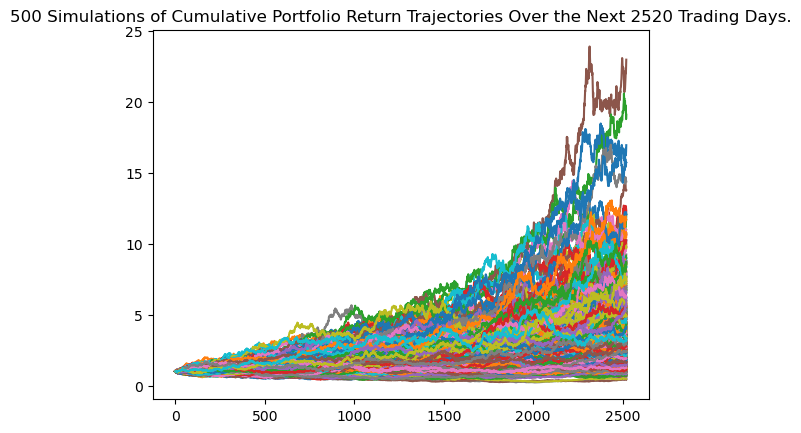

In [61]:
# Plot simulation outcomes 
line_plot = MC_10years.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("images/Monte_Carlo_10_year", bbox_inches="tight")

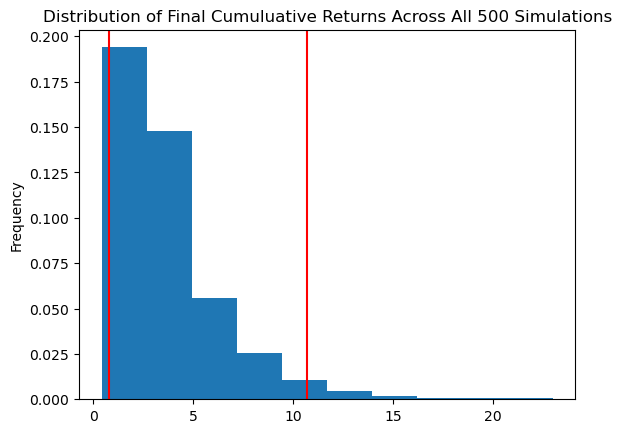

In [62]:
# Plot probability distribution and confidence intervals
distribution_plot = MC_10years.plot_distribution()


# Save the plot for future usage
distribution_plot.get_figure().savefig('images/Monte_Carlo_10year_dist_plot.png',bbox_inches='tight')

In [63]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_summary = MC_10years.summarize_cumulative_return()

# Print summary statistics
print(MC_summary)

count           500.000000
mean              3.706531
std               2.758421
min               0.414868
25%               1.973705
50%               2.941635
75%               4.483458
max              22.997044
95% CI Lower      0.795771
95% CI Upper     10.694319
Name: 2520, dtype: float64


In [66]:
# Set initial investment
initial_investment_10year = current_portfolio_value

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes.
ci_lower_ten = round(MC_summary[8]*initial_investment_10year,2)
ci_upper_ten = round(MC_summary[9]*initial_investment_10year,2)
ci_average_ten = round((ci_lower_ten + ci_upper_ten)/2,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10year:.2f} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")
print(f" On average ${ci_average_ten}")

There is a 95% chance that an initial investment of $4489.30 in the portfolio over the next 10 years will end within in the range of $3572.45 and $48010.01
 On average $25791.23


In [65]:
# Calculate annual return and annual percetage return on average. 
annual_return_10 = ((ci_average_ten - initial_investment_10year) / 10)
annual_percent_10 = annual_return_10 / initial_investment_10year


print(f"Annual Percent Change (10 years): {annual_percent_10 * 100:.2f}%")

Annual Percent Change (10 years): 47.45%
